Quantum computers gives us the opportunity to solve the problems which we were never able to solve using classic computers but as of now we don't have any quantum computer which we can use to solve some real life problem because quantum hardware are very sensitive to noise. 

So till the time we don't have actual useful quantum computer we simulate and mimic the actual condition of quantum computers on quantum simulator running on clasical machines.

While mimicing we have to use the backend properties of actual quantum computers provided by many operators in whicc IBM machines are very dominant and useful.

As the quantum computer are very prone to errors we have to use mathematical models to represent these errors to use in quantum simulators

Gate errors: Every gate in quantum computers produces some errors and these errors are very unpredictble to model these errors we use combination of depolarization errors which are Pauli(I, X, Y, Z)

Single-qubit gate errors consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.

Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.

Single-qubit readout errors on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the thermal_relaxation_error function from aer.noise.errors module, along with the individual qubit and 
 parameters, and the gate_time parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the gate_error value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit readout_errors.

so here we have used least busy servers from IBMQ and import all the errors NoiseModel, QuantumError, ReadoutError,
    pauli error, depolarizing error, thermal relaxation error

In [ ]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy #added this line to have least busy resource
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

import numpy as np


# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

Here all the desired property of the backend has been defined

In [13]:
from qiskit.providers.fake_provider import FakeVigo
device_backend = least_busy(provider.backends(simulator=False, n_qubits=7))  # select the least busy backend
# will use ibm_brisbane as backend

properties = device_backend.properties()
temp = 0
noise_model= NoiseModel.from_backend_properties(
        backend_properties=properties,
        gate_error=True,
        readout_error=True,
        thermal_relaxation=True,
        temperature=0,
        gate_lengths=None,
        gate_length_units="ns",
        dt=None,
    )
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'id', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,))]


For a simulation here we have used a standard GHZ circuit of 3 qubits 

In [3]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

Below cell execulte the circuit on a ideal AER simulator which don't have any Noise and errors

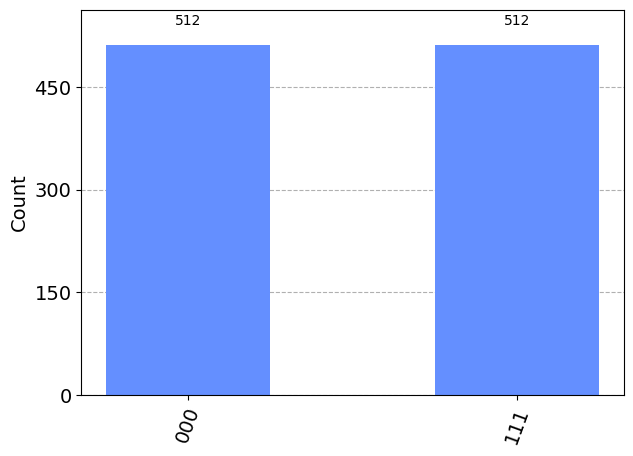

In [4]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

This cell we use the Noisy simulator and you can see the impact of noise, states are generated which are never desired with some probabilities

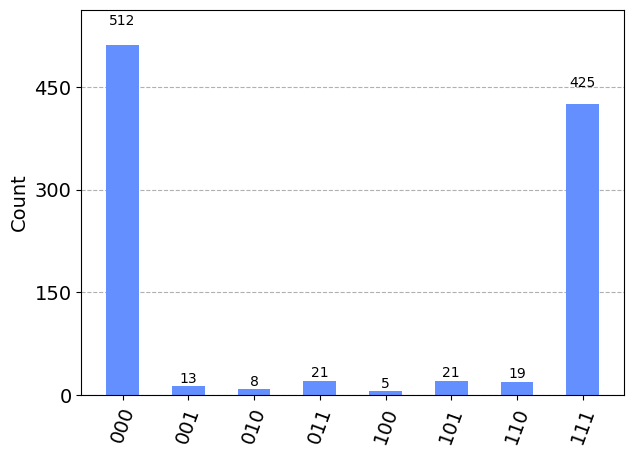

In [16]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

To overcome these undesirable states we want to use quantum error correction, Error mitigation seeks to reduce these effects at the software level by compiling quantum programs in clever ways.

So for quantum error correction we used two techniques 

1. ZNE(Zero Noise Extrapolation): It is an error mitigation technique used to extrapolate the noiseless expectation value of an observable from a range of expectation values computed at different noise levels. This process works in two steps:

Step 1: Intentionally scale noise. This can be done with different methods. Pulse-stretching can be used to increase the noise level of a quantum computation. Similar results can be obtained, at a gate-level, with unitary folding or identity insertion scaling.

Step 2: Extrapolate to the noiseless limit. This can be done by fitting a curve (often called extrapolation model) to the expectation values measured at different noise levels to extrapolate the noiseless expectation value.

Zero noise extrapolation is one of the simplest error mitigation techniques and, in many practical situations, it can be applied with a relatively small sampling cost.

In some instances the results of the extrapolation can exhibit a large bias. ZNE may not be helpful in cases where a low degree polynomial curve obtained by fitting the noisy expectation values does not match the zero-noise limit. When using circuits of less trivial depth on real devices, the lowest error points may be too noisy for the extrapolation to show improvement over the unmitigated result





2. PEC(Probabilistic Error Cancellation): It is an error mitigation technique in which ideal operations are represented as linear combinations of noisy operations. In PEC, unbiased estimates of expectation values are obtained by Monte Carlo averaging over different noisy circuits

The main advantage of PEC is that, under the assumption of perfect gate tomography, it provides an unbiased estimation of expectation values. This means that, in the limit of many samples, the error mitigated expectation values converge to the ideal expectation values.

The general workflow of PEC is similar to the workflow of ZNE. The main difference is that in ZNE the auxiliary circuits are obtained by noise scaling, while in PEC they are probabilistically generated. As a consequence, the final inference step is different too. The inference step of PEC is based on the Monte Carlo estimation protocol 

It is a noise-aware error mitigation technique which is based on two main ideas:

The first idea is to express ideal gates as linear combinations of implementable noisy gates. These linear combinations are called quasi-probability representations 
The second idea is to probabilistically sample from the previous quasi-probability representations to approximate quantum expectation values via a Monte Carlo average.



In [10]:
import qiskit
from mitiq import pec
from mitiq import zne
from mitiq.rem import generate_tensored_inverse_confusion_matrix
from typing import Any, Sequence
from qiskit.result import LocalReadoutMitigator
from mitiq.pec.representations.depolarizing import represent_operation_with_local_depolarizing_noise,represent_operation_with_global_depolarizing_noise
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise


error_list = [('id', (0,),0), ('id', (1,),0), ('id', (2,),0), ('id', (3,),0),
              ('id', (4,),0), ('id', (5,),0), ('id', (6,),0), ('sx', (0,),0), 
              ('sx', (1,),0), ('sx', (2,),0), ('sx', (3,),0), ('sx', (4,),0), 
              ('sx', (5,),0), ('sx', (6,),0), ('x', (0,),0), ('x', (1,),0), 
              ('x', (2,),0), ('x', (3,),0), ('x', (4,),0), ('x', (5,),0), 
              ('x', (6,),0), ('cx', (6, 5),0), ('cx', (5, 6),0), ('cx', (5, 4),0),
              ('cx', (4, 5),0), ('cx', (5, 3),0), ('cx', (3, 5),0), ('cx', (1, 3),0),
              ('cx', (3, 1),0), ('cx', (2, 1),0), ('cx', (1, 2),0), ('cx', (0, 1),0), 
              ('cx', (1, 0),0)]
# will import the error data once pec method is avaliable

def rep_for_simulator(error_list):
    '''
    error_list = [[gate_name:str,(qubit1,qubit2),error]]
    '''
    rep = []
    for i in error_list:
        c = qiskit.QuantumCircuit(7)
        if i[0]=='cx':
            c.cx(i[1][0],i[1][1])
            depolarizing_rep = represent_operation_with_global_depolarizing_noise(
                ideal_operation=c,
                noise_level=i[2],
            )
        else:
            if i[0]=='id':
                c.id(i[1][0])
            elif i[0]=='sx':
                c.sx(i[1][0])
            elif i[0]=='x':
                c.x(i[1][0])
            depolarizing_rep = represent_operation_with_local_depolarizing_noise(
                ideal_operation=c,
                noise_level=i[2],
            )
                  
        rep += [depolarizing_rep]
    return rep

rep_for_PEC = rep_for_simulator(error_list)

class AfterErrorMitigation:
    '''the error mitigation for the sepcific noisy simulaor 'sim_noise'
    '''
    def __init__(self, circuit: QuantumCircuit):
        self.circuit = transpile(circuit, sim_noise)
        self.qubits: list = circuit.qubits
        self.num_qubits = len(self.qubits)
        self.simulator = sim_noise
        
    def noisy_executor_after_rem(self, circuit, shots: int = 1024):
        """Returns the expectation value to be mitigated.
            Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
    
        # Simulate the circuit with noise
    
        job = qiskit.execute(
            experiments=circuit,
            backend=sim_noise,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )
        
        # build local readout error mitigator
        A_list=[]
        '''
        To do: add value to p1 and p0 for each qubits
        '''
        for i in self.qubits:
            p = properties.readout_error(i.index)
            A_i = np.array([[1.0 - p, p],
                            [p, 1.0 - p]])
            A_list += [A_i]
        mitigator = LocalReadoutMitigator(A_list)
        
        # Convert from raw measurement counts to the expectation value
        counts = job.result().get_counts()  
        mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
        
        # the probability of state 001, the ideal value is 0
        prob_001 = mitigated_quasi_probs.get(1)
        return prob_001
   
    def combine_PEC(self):
        rep = rep_for_PEC
        mitigated = pec.execute_with_pec(self.circuit, self.noisy_executor_after_rem, representations=rep)
        return mitigated
    
    def combine_ZNE(self):
        linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 3.0, 5.0])
        mitigated = zne.execute_with_zne(self.circuit, self.noisy_executor_after_rem, factory=linear_factory)
        return mitigated
        
    def run(self, zne:bool = True, pec:bool = False):
        """returns the mitigated value after REM, with ZNE or PEC
        
        """
        if zne and pec:
            print('can not mitigate with both zne and pec, otherwise the cost would be too much')
        elif zne:
            return self.combine_ZNE()
        elif pec:
            #return self.combine_PEC()
            print('due to mitiq bug, pec is not avaliable for now, will update later')
        else:
            return self.noisy_executor_after_rem(self.circuit)
        

In [11]:
# return the probability to get state 001
# which the ideal probability is 0
AFE = AfterErrorMitigation(circ)
AFE.run()

/tmp/ipykernel_7130/770759110.py:83: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  p = properties.readout_error(i.index)


-0.00620783260399322